In [1]:
from glob import glob
import pandas as pd
from re import sub

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt


from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer, PorterStemmer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline

In [3]:
import numpy as np
path = "/home/rkamath/Downloads/nlp/"

In [4]:
train_df = pd.read_csv(path+"train.csv")
train_df = train_df.fillna('None')

In [5]:
test_df = pd.read_csv(path+"test.csv")
test_df = test_df.fillna('None')

In [6]:
submission_df = test_df['id']

In [7]:
#String HTTP is causing too much noise
def repl(text):
    return text.replace("http","")

In [8]:
train_df['text'] = train_df['text'].apply(lambda x: repl(x))

In [9]:
test_df['text'] = test_df['text'].apply(lambda x: repl(x))


In [10]:
#Calculate the word which has max probabilty for contribution of disaster
ag = train_df.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Disaster Probability'})
ag.sort_values('Disaster Probability', ascending=False).head(10)

,Count,Disaster Probability
keyword,,
wreckage,39,1.000000
debris,37,1.000000
derailment,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


In [11]:
train_df.target.unique()

array([1, 0])

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7613 non-null object
location    7613 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


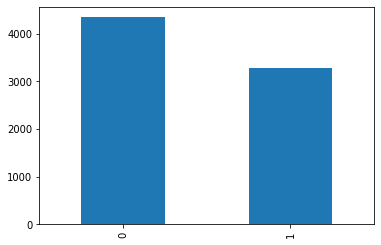

In [13]:
train_df['target'].value_counts().plot(kind= "bar")

In [14]:
def remove_URL(text):
    url = RegexpTokenizer(r'https?://\S+|www\.\S+', gaps = True)
    return " ".join(url.tokenize(text))

def stopWords(tweet):  
    stop_words, toker = stopwords.words('english'), TweetTokenizer()
    words_tokens = toker.tokenize(tweet)
    return " ".join([word for word in  words_tokens if not word in stop_words])

def remove_pontucations(text):
    tokenizer_dots = RegexpTokenizer(r'\w+')
    return " ".join(tokenizer_dots.tokenize(text))


    return tweet

def remove_words_min(text):
    tmp = text
    
    for x in tmp.split():
        if len(x) < 2:
            tmp = tmp.replace(x, '')
    return " ".join(tmp.split())


In [15]:
train_df.text = train_df.text.apply(lambda x: x.lower()) 
train_df.text = train_df.text.apply(lambda x: " ".join(x.split())) 
train_df.text = train_df.text.apply(lambda x: sub(r'\d+', '', x)) 
train_df.text = train_df.text.apply(lambda x: remove_pontucations(x)) 
train_df.text = train_df.text.apply(lambda x: stopWords(x))
train_df.text = train_df.text.apply(lambda x: x.replace('_', ' '))
train_df.text = train_df.text.apply(lambda x: remove_words_min(x))

In [16]:
train_df.to_csv("train.csv",index=False)

In [17]:
test_df.text = test_df.text.apply(lambda x: x.lower()) 
test_df.text = test_df.text.apply(lambda x: " ".join(x.split())) 
test_df.text = test_df.text.apply(lambda x: sub(r'\d+', '', x)) 
test_df.text = test_df.text.apply(lambda x: remove_pontucations(x)) 
test_df.text = test_df.text.apply(lambda x: stopWords(x))
test_df.text = test_df.text.apply(lambda x: x.replace('_', ' '))
test_df.text = test_df.text.apply(lambda x: remove_words_min(x))

In [18]:
test_df.to_csv("test.csv",index=False)

In [19]:
y = train_df['target']
X = train_df['text']

In [20]:
X_disaster = X[y==1]

In [21]:
X_disaster.head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [22]:
%%time
corpus_disaster = [word_tokenize(t) for t in X_disaster]

CPU times: user 276 ms, sys: 7.73 ms, total: 283 ms
Wall time: 283 ms


In [23]:
lowercase = [[t.lower() for t in doc] for doc in corpus_disaster]


In [24]:
stop_words = stopwords.words('english')

In [25]:
no_stops = [[t for t in doc if t not in stop_words] for doc in lowercase]

In [26]:
alphas_disaster= [[token for token in doc if token.isalpha()] for doc in no_stops]


In [27]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stemmed_disaster = [[stemmer.stem(token) for token in doc] for doc in alphas_disaster]

In [28]:
nb_words_disaster_nostop = [len(tokens) for tokens in no_stops]

In [29]:
avg_nostop = np.mean(nb_words_disaster_nostop)
avg_nostop

11.133598287985325

In [30]:
nb_words_disaster_stop = [len(tokens) for tokens in lowercase]
avg_stop = np.mean(nb_words_disaster_stop)
avg_stop

11.148272699480282

In [31]:
np.median(nb_words_disaster_nostop)

11.0

In [32]:
np.median(nb_words_disaster_stop)

11.0

In [33]:
nb_words_disaster_stop = pd.Series(nb_words_disaster_stop)
nb_words_disaster_nostop = pd.Series(nb_words_disaster_nostop)

In [34]:
df_disaster =  pd.DataFrame(X_disaster)

In [35]:
df_disaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3271 entries, 0 to 7612
Data columns (total 1 columns):
text    3271 non-null object
dtypes: object(1)
memory usage: 51.1+ KB


In [36]:
df_disaster = pd.concat([X_disaster.reset_index(), nb_words_disaster_nostop, nb_words_disaster_stop], axis=1).set_index('index').rename(columns={
    0: "nb_words_no_stop", 1: 'nb_words_stop'
})
df_disaster.head()

,text,nb_words_no_stop,nb_words_stop
index,,,
0,deeds reason earthquake may allah forgive us,7,7
1,forest fire near la ronge sask canada,7,7
2,residents asked shelter place notified officer...,11,11
3,people receive wildfires evacuation orders cal...,6,6
4,got sent photo ruby alaska smoke wildfires pou...,9,9


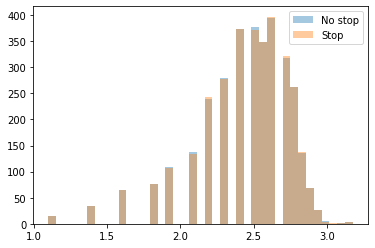

In [37]:
import seaborn as sns
sns.distplot(np.log1p(nb_words_disaster_nostop), kde=False, label="No stop")
sns.distplot(np.log1p(nb_words_disaster_stop), kde=False, label="Stop")
plt.legend();

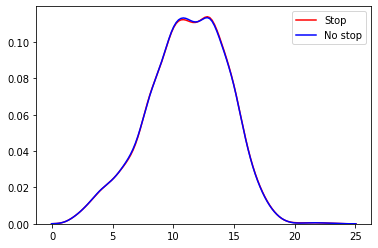

In [38]:
sns.distplot(nb_words_disaster_stop, hist=False, color='red', label='Stop')
sns.distplot(nb_words_disaster_nostop, hist=False, color='blue', label='No stop')
plt.legend();


In [39]:
from collections import defaultdict

counter = defaultdict(int)
for doc in alphas_disaster:
    for token in doc:
        counter[token] += 1

from collections import Counter

c = Counter(counter)

c.most_common(10)

[('co', 2509),
 ('fire', 180),
 ('news', 144),
 ('amp', 135),
 ('via', 120),
 ('disaster', 118),
 ('california', 115),
 ('suicide', 112),
 ('people', 104),
 ('police', 104)]

In [40]:
X_nondisaster = X[y == 0]


In [41]:
corpus_nondisaster = [word_tokenize(t) for t in X_nondisaster]
lowercase_nondisaster = [[t.lower() for t in doc] for doc in corpus_nondisaster]
no_stop_nondisaster = [[t for t in doc if t not in stop_words] for doc in lowercase_nondisaster]
alphas_nondisaster = [[token for token in doc if token.isalpha()] for doc in no_stop_nondisaster]
nb_words_nondisaster_nostop = [len(t) for t in no_stop_nondisaster]

In [42]:
avg_words_nondisaster_nostop = np.mean(nb_words_nondisaster_nostop)
avg_words_nondisaster_nostop

9.71579917088899

In [43]:
nb_words_nondisaster_stop = [len(t) for t in lowercase_nondisaster]
avg_words_nondisaster = np.mean(nb_words_nondisaster_stop)
avg_words_nondisaster

9.727775218793182

In [44]:
np.median(nb_words_nondisaster_nostop)


10.0

In [45]:
np.median(nb_words_nondisaster_stop)

10.0

In [46]:
df_nondisaster =  pd.DataFrame(X_nondisaster)

In [47]:
df_nondisaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4342 entries, 15 to 7593
Data columns (total 1 columns):
text    4342 non-null object
dtypes: object(1)
memory usage: 67.8+ KB


In [48]:
nb_words_nondisaster_stop = pd.Series(nb_words_nondisaster_stop)
nb_words_nondisaster_nostop = pd.Series(nb_words_nondisaster_nostop)

In [49]:
df_nondisaster = pd.concat([X_nondisaster.reset_index(), nb_words_nondisaster_nostop, nb_words_nondisaster_stop], axis=1).set_index('index').rename(columns={
    0: "nb_words_no_stop", 1: 'nb_words_stop'
})
df_nondisaster.head()

,text,nb_words_no_stop,nb_words_stop
index,,,
15,man,1,1
16,love fruits,2,2
17,summer lovely,2,2
18,car fast,2,2
19,goooooooaaaaaal,1,1


In [50]:
from collections import defaultdict

counter_nondisaster = defaultdict(int)
for doc in alphas_nondisaster:
    for token in doc:
        counter[token] += 1

from collections import Counter

c_nondisaster = Counter(counter)

c_nondisaster.most_common(10)

[('co', 4710),
 ('like', 345),
 ('amp', 343),
 ('fire', 249),
 ('get', 229),
 ('new', 224),
 ('via', 219),
 ('news', 201),
 ('people', 199),
 ('one', 197)]

In [51]:
from gensim import corpora
dictionary = corpora.Dictionary(alphas_disaster)

In [52]:
corpus_1 = [dictionary.doc2bow(t) for t in alphas_disaster]

In [53]:
from gensim.models.ldamodel import LdaModel

In [54]:
%%time
lda_model = LdaModel(
    corpus=corpus_1, id2word=dictionary, num_topics=4, random_state=42)

CPU times: user 1.61 s, sys: 19.1 ms, total: 1.63 s
Wall time: 1.63 s


In [55]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.058*"co" + 0.009*"suicide" + 0.008*"disaster" + 0.006*"mh" + '
  '0.006*"killed" + 0.006*"typhoon" + 0.005*"bombing" + 0.005*"obama" + '
  '0.005*"saudi" + 0.005*"police"'),
 (1,
  '0.058*"co" + 0.007*"old" + 0.006*"suicide" + 0.005*"pkk" + 0.004*"via" + '
  '0.004*"refugees" + 0.004*"released" + 0.004*"yr" + 0.004*"bomber" + '
  '0.004*"turkey"'),
 (2,
  '0.039*"co" + 0.007*"oil" + 0.007*"news" + 0.005*"get" + 0.005*"california" '
  '+ 0.004*"nuclear" + 0.004*"bigger" + 0.003*"spill" + 0.003*"weapons" + '
  '0.003*"police"'),
 (3,
  '0.062*"co" + 0.008*"families" + 0.008*"legionnaires" + 0.006*"pm" + '
  '0.006*"wreckage" + 0.004*"amp" + 0.004*"severe" + 0.004*"storm" + '
  '0.004*"affected" + 0.004*"airport"')]


In [56]:
%%time
lda_model_1 = LdaModel(
    corpus=corpus_1, id2word=dictionary, num_topics=4, random_state=42, iterations=10)

CPU times: user 691 ms, sys: 6.37 ms, total: 697 ms
Wall time: 695 ms


In [57]:
from pprint import pprint
pprint(lda_model_1.print_topics())

[(0,
  '0.056*"co" + 0.007*"disaster" + 0.007*"suicide" + 0.006*"killed" + '
  '0.005*"mh" + 0.005*"typhoon" + 0.005*"police" + 0.005*"obama" + '
  '0.004*"confirmed" + 0.004*"migrants"'),
 (1,
  '0.060*"co" + 0.007*"suicide" + 0.007*"old" + 0.005*"families" + '
  '0.004*"fatal" + 0.004*"bomb" + 0.004*"pkk" + 0.004*"via" + 0.004*"bomber" + '
  '0.004*"yr"'),
 (2,
  '0.039*"co" + 0.008*"news" + 0.006*"oil" + 0.005*"california" + 0.004*"mass" '
  '+ 0.003*"bigger" + 0.003*"northern" + 0.003*"spill" + 0.003*"police" + '
  '0.003*"wildfire"'),
 (3,
  '0.064*"co" + 0.006*"pm" + 0.004*"storm" + 0.004*"legionnaires" + '
  '0.004*"amp" + 0.004*"airport" + 0.004*"wreckage" + 0.004*"watch" + '
  '0.004*"families" + 0.003*"hiroshima"')]


In [58]:
import pyLDAvis.gensim

In [59]:
pyLDAvis.gensim.prepare(lda_model, corpus_1, dictionary)

/home/rkamath/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.129724 -0.015964       1        1  28.333817
3     -0.044564  0.034780       2        1  27.788570
1     -0.057155 -0.106139       3        1  23.487291
2     -0.028005  0.087323       4        1  20.390316, topic_info=     Category        Freq          Term       Total  loglift  logprob
3729  Default   87.000000  legionnaires   87.000000  30.0000  30.0000
5245  Default   56.000000           oil   56.000000  29.0000  29.0000
1465  Default   66.000000           old   66.000000  28.0000  28.0000
961   Default  154.000000       suicide  154.000000  27.0000  27.0000
1762  Default  111.000000      families  111.000000  26.0000  26.0000
...       ...         ...           ...         ...      ...      ...
1319   Topic4   19.095488         video   75.219627   0.2192  -5.9631
8      Topic4   19.635296          fire   88.348297   0.0862  -5.9353
146

In [60]:
weight_topic = lda_model_1.top_topics(corpus=corpus_1, dictionary=dictionary, topn=30)

In [61]:
weight_topic

[([(0.064012125, 'co'),
   (0.005733884, 'pm'),
   (0.004070529, 'storm'),
   (0.0040326025, 'legionnaires'),
   (0.0039979415, 'amp'),
   (0.0038104337, 'airport'),
   (0.0036124478, 'wreckage'),
   (0.0035808987, 'watch'),
   (0.003539196, 'families'),
   (0.003418009, 'hiroshima'),
   (0.0034039372, 'severe'),
   (0.00303929, 'get'),
   (0.0028597675, 'war'),
   (0.0028282867, 'fires'),
   (0.002643844, 'warning'),
   (0.0025912363, 'disaster'),
   (0.002576541, 'swallowed'),
   (0.0025649653, 'people'),
   (0.0025446925, 'thunderstorm'),
   (0.0025307874, 'sandstorm'),
   (0.002503125, 'affected'),
   (0.002462419, 'minute'),
   (0.0022575844, 'us'),
   (0.0022457943, 'like'),
   (0.0021957455, 'fire'),
   (0.0021765165, 'news'),
   (0.0021325739, 'nuclear'),
   (0.002125056, 'violent'),
   (0.0021176932, 'police'),
   (0.0020475246, 'massacre')],
  -15.241530320805616),
 ([(0.03921163, 'co'),
   (0.0075217835, 'news'),
   (0.0064786584, 'oil'),
   (0.0053662485, 'california'),
   

In [62]:
fire,news,amp,bomber = weight_topic

In [63]:
fire = fire[0]
fire = [tup[1] for tup in fire]
fire


['co',
 'pm',
 'storm',
 'legionnaires',
 'amp',
 'airport',
 'wreckage',
 'watch',
 'families',
 'hiroshima',
 'severe',
 'get',
 'war',
 'fires',
 'warning',
 'disaster',
 'swallowed',
 'people',
 'thunderstorm',
 'sandstorm',
 'affected',
 'minute',
 'us',
 'like',
 'fire',
 'news',
 'nuclear',
 'violent',
 'police',
 'massacre']

In [64]:
news = news[0]
news = [tup[1] for tup in news]
news

['co',
 'news',
 'oil',
 'california',
 'mass',
 'bigger',
 'northern',
 'spill',
 'police',
 'wildfire',
 'abc',
 'nuclear',
 'homes',
 'legionnaires',
 'tornado',
 'may',
 'home',
 'murder',
 'amp',
 'costlier',
 'refugio',
 'video',
 'fire',
 'fires',
 'projected',
 'thunderstorm',
 'storm',
 'time',
 'emergency',
 'razed']

In [65]:
amp = amp[0]
amp = [tup[1] for tup in amp]
amp

['co',
 'disaster',
 'suicide',
 'killed',
 'mh',
 'typhoon',
 'police',
 'obama',
 'confirmed',
 'migrants',
 'malaysia',
 'saudi',
 'bombing',
 'wounded',
 'people',
 'investigators',
 'mosque',
 'rescuers',
 'video',
 'bomber',
 'hundreds',
 'fire',
 'nuclear',
 'attack',
 'amp',
 'northern',
 'spill',
 'suspect',
 'dead',
 'searching']

In [66]:
bomber = bomber[0]
bomber = [tup[1] for tup in bomber]
bomber

['co',
 'suicide',
 'old',
 'families',
 'fatal',
 'bomb',
 'pkk',
 'via',
 'bomber',
 'yr',
 'year',
 'detonated',
 'bestnaijamade',
 'army',
 'released',
 'turkey',
 'car',
 'crash',
 'california',
 'wildfire',
 'storm',
 'terrorist',
 'outbreak',
 'live',
 'pic',
 'mp',
 'refugees',
 'legionnaires',
 'train',
 'tragedy']

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090,), (1523,), (6090,), (1523,))

In [72]:
tvec = TfidfVectorizer(stop_words='english')

In [73]:
tf = tvec.fit_transform(X_train)
tf

<6090x18037 sparse matrix of type '<class 'numpy.float64'>'
	with 53777 stored elements in Compressed Sparse Row format>

In [74]:
cvec = CountVectorizer(analyzer='word', stop_words='english', tokenizer=word_tokenize)

In [75]:
from sklearn.decomposition import TruncatedSVD

In [76]:
svd = TruncatedSVD(n_components=100, random_state=42)

In [77]:
preprocessing_pipeline = Pipeline([('tvec', tvec), ('svd', svd)])

In [78]:
preprocessing_pipeline.fit_transform(X_train)

array([[ 1.74536214e-02, -5.01073938e-03, -3.45820047e-03, ...,
         4.01308246e-02, -1.89395463e-02,  5.65651366e-03],
       [ 4.61585813e-02, -1.41737028e-02, -1.04687336e-02, ...,
         8.21501916e-05, -1.15394249e-03,  4.99390404e-02],
       [ 2.84181732e-02, -1.16705663e-02, -1.02802422e-02, ...,
         1.54380483e-02,  6.44256198e-03, -1.77225572e-04],
       ...,
       [ 1.21985532e-02, -3.33574904e-03, -3.68142947e-03, ...,
        -1.33441788e-02, -3.73549468e-02,  6.18495652e-02],
       [ 1.40161826e-02, -5.82602006e-03, -2.43378619e-03, ...,
         3.15776820e-02, -6.15884130e-03, -2.97862047e-02],
       [ 1.42879198e-02, -5.96304121e-03,  2.61542496e-03, ...,
         1.87492854e-02,  1.55616691e-02, -3.74107128e-02]])

In [79]:
mnb = MultinomialNB()

pipe_mnb = Pipeline([('vectorizer', cvec), ('mnb', mnb)])

pipe_mnb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function word_tokenize at 0x7f7829f64400>,
                                 vocabulary=None)),
                ('mnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [80]:
y_pred_mnb = pipe_mnb.predict(X_test)


In [81]:
cm = confusion_matrix(y_test, y_pred_mnb)
cm

array([[745, 124],
       [167, 487]])

In [82]:
cr = classification_report(y_test, y_pred_mnb)
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       869
           1       0.80      0.74      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [83]:
test_df = test_df['text']

In [84]:
actual_preds = pd.read_csv("/home/rkamath/Downloads/submission.csv")

y_test_acc = list(actual_preds['target'])

In [85]:
y_preds = pipe_mnb.predict(test_df)

In [86]:
y_preds

array([1, 1, 1, ..., 1, 1, 1])

In [87]:
cr = classification_report(y_test_acc, y_preds)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1861
           1       0.79      0.70      0.74      1402

    accuracy                           0.79      3263
   macro avg       0.79      0.78      0.79      3263
weighted avg       0.79      0.79      0.79      3263



In [102]:
lr = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=0)

pipe_lr = Pipeline([('vectorizer', cvec), ('lr', lr)])

pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function word_tokenize at 0x7f7829f64400>,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
              

In [103]:
y_pred_lr = pipe_lr.predict(X_test)
y_pred_lr

array([1, 0, 1, ..., 0, 0, 0])

In [104]:
cm = confusion_matrix(y_test, y_pred_lr)
cm

array([[772,  97],
       [182, 472]])

In [91]:
cr = classification_report(y_test, y_pred_lr)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.80      0.80      1523



In [92]:
y_preds = pipe_lr.predict(test_df)

In [93]:
cr = classification_report(y_test_acc, y_preds)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1861
           1       0.83      0.65      0.73      1402

    accuracy                           0.79      3263
   macro avg       0.80      0.78      0.78      3263
weighted avg       0.80      0.79      0.79      3263



In [94]:
#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=100)

pipe_rf = Pipeline([('vectorizer', cvec), ('rf', rf)])

#Train the model using the training sets y_pred=clf.predict(X_test)
pipe_rf.fit(X_train,y_train)

y_pred_rf = pipe_rf.predict(X_test)

In [95]:
cr = classification_report(y_test, y_pred_rf)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       869
           1       0.85      0.64      0.73       654

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



In [96]:
y_preds = pipe_rf.predict(test_df)

In [97]:
cr = classification_report(y_test_acc, y_preds)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.92      0.82      1861
           1       0.84      0.59      0.69      1402

    accuracy                           0.78      3263
   macro avg       0.79      0.75      0.76      3263
weighted avg       0.79      0.78      0.77      3263



In [98]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
pipe_xgb = Pipeline([('vectorizer', cvec), ('xgb', xgb)])

pipe_xgb.fit(X_train, y_train)
# make predictions for test data
y_pred_xgb = pipe_xgb.predict(X_test)

In [99]:
cr = classification_report(y_test, y_pred_xgb)
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       869
           1       0.89      0.45      0.60       654

    accuracy                           0.74      1523
   macro avg       0.80      0.70      0.70      1523
weighted avg       0.78      0.74      0.72      1523



In [100]:
y_preds = pipe_xgb.predict(test_df)

In [101]:
cr = classification_report(y_test_acc, y_preds)
print(cr)

              precision    recall  f1-score   support

           0       0.68      0.95      0.79      1861
           1       0.86      0.40      0.54      1402

    accuracy                           0.71      3263
   macro avg       0.77      0.67      0.67      3263
weighted avg       0.75      0.71      0.68      3263

